In [1]:
import os
from imagegrains import grainsizing, plotting, segmentation_helper, data_loader, gsd_uncertainty
from cellpose import io
import pandas as pd
import matplotlib.pyplot as plt

## Download pre-trained models and demo data  
If you have not donwloaded the pre-trained models and demo data yet from github, please run the following cell to download them.

In [2]:
download_path = data_loader.download_files()
print("Files saved to: ", download_path)

Files saved to:  C:/Users/Mair/imagegrains


Instead of using the demo files, you can use your own files. To do so, please change the paths in the following cell to your own files.

In [3]:
# Path to the images
image_path = 'F:/demo/K1/'
# Path to the segementation model
model_path ='F:/git/grain_seg_ml/models/full_set_1.170223'

To use the demo files, please run the following cell.

In [4]:
image_path = f'{download_path}/demo_data/K1/'
model_path = f'{download_path}/models/full_set_1.170223'

## Complete ImageGrains analysis

### Segment image(s)

C:/Users/Mair/imagegrains/demo_data/K1: 100%|██████████| 1/1 [00:36<00:00, 36.68s/image]


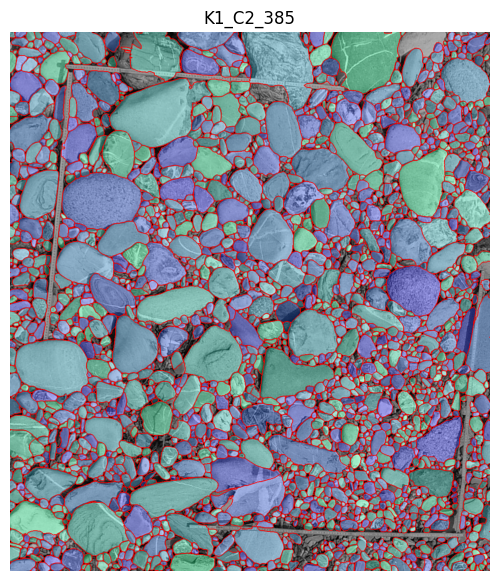

In [5]:
# Run segmentation
segmentation_helper.predict_dataset(image_path,model_path,mute=True,return_results=False,save_masks=True);
#get image and segmentation mask paths...
imgs,_,preds = data_loader.dataset_loader(image_path,pred_str='pred')
#... and plot them
plt.figure(figsize=(7,7))
plotting.plot_single_img_pred(imgs[0],preds[0],show=True)

### Optional filter and resample masks

image shape: 1200 x 1350
number of Wolman nodes: 51 x 58


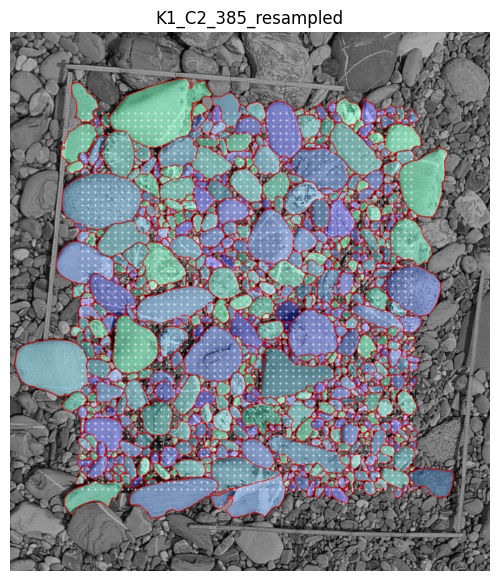

In [6]:
#load the segmentation masks from file
masks = io.imread(preds[0])
#define the filters to apply to the segmentation masks
filters= {'edge':[True,.15],'px_cutoff':[True,12]}
#resample masks and apply the filters
grid_resampled,xx,yy = grainsizing.resample_masks(masks,filters=filters,grid_size=16.5,mute=False)
#save resampled mask
io.imsave(image_path+'/K1_C2_385_resampled.tif',grid_resampled)
#plot resampled mask
plt.figure(figsize=(7,7))
plotting.plot_single_img_mask(io.imread(imgs[0]),grid_resampled,file_id='K1_C2_385_resampled')
#plot grid
plt.scatter(yy,xx,marker='.',color='w',s=0.5);

### Calculate grain properties

C:\Users\Mair\imagegrains\demo_data\K1:   0%|          | 0/1 [00:00<?, ?file/s]

C:\Users\Mair\imagegrains\demo_data\K1: 100%|██████████| 1/1 [00:00<00:00,  1.15file/s]


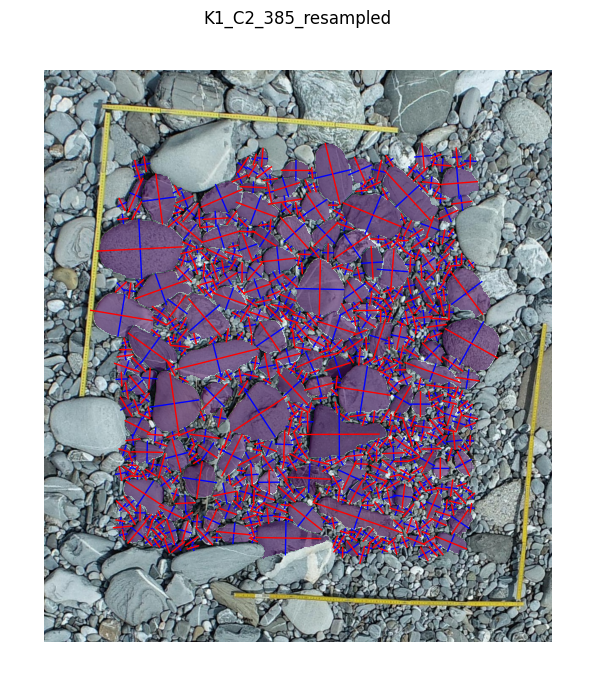

In [7]:
#measure the grains and save the results
grains,grains_props,grain_id = grainsizing.batch_grainsize(image_path,filters=filters,mask_str='_resampled',mute=True,return_results=True)
#set the resolution in mm/px
resolution = 0.39
#scale with the image resolution
grainsizing.re_scale_dataset(image_path,resolution=resolution,gsd_str='_grains',save_gsds=True)

#define plot elements
elements= ['image','mask','ellipse_b','ellipse_a']
#plot
plt.figure(figsize=(7,7))
plotting.all_grains_plot(grid_resampled,props=grains_props[0],elements=elements,image=io.imread(imgs[0]),title=grain_id[0])
plt.savefig(image_path+'/K1_C2_385_resampled_grains.png',dpi=300)

### Grain size distribution and uncertainty

In [9]:
#load the resampled grains
grains_scaled = data_loader.load_grain_set(image_path,gsd_str='resampled_grains_re_scaled')
#calculate the gsd for one column (e.g. b-axis with ellispe fit)
column_name = 'ell: b-axis (mm)'
#set uncertainty method
method = 'bootstrapping'
#calculate the gsd and uncertainty
res_dict_bs = gsd_uncertainty.dataset_uncertainty(gsds=grains_scaled,num_it=1000,method=method,mute=True,column_name=column_name,save_results=False,return_results=True,sep=',',gsd_id=grain_id)

ell: b-axis (mm) bootstrapping: 100%|██████████| 1/1 [00:00<00:00,  1.03gsd/s]


In [10]:
#compile full results into a dataframe and save it
full_gsd_results = pd.DataFrame({f'{column_name}_perc_lower_CI':res_dict_bs[grain_id[0]][2],
                                f'{column_name}_perc_median':res_dict_bs[grain_id[0]][0],
                                f'{column_name}_perc_upper_CI':res_dict_bs[grain_id[0]][1],
                                f'{column_name}_perc_value':res_dict_bs[grain_id[0]][3]})
#create output directory
out_dir = image_path + '/GSD_uncertainty/'
os.makedirs(out_dir,exist_ok=True)
#save the results
full_gsd_results.to_csv(f'{out_dir}/{grain_id[0]}_{method}_full_uncertainty.csv')


In [11]:
# calculate and save key percentile summary
summary_df = grainsizing.summary_statistics(grains_scaled,grain_id,res_dict=res_dict_bs,data_id=grain_id[0],save_summary=True)
summary_df.head()

,Image/Masks,number of grains,D16,CI D16 (95%),D50,CI D50 (95%),D84,CI D84 (95%),D96,CI D96 (95%),unit,axis,method,grain approximation
0,K1_C2_385_resampled,597,13.8,[5.3 5.6],19.5,[7.3 7.9],34.9,[11.9 14.7],70.2,[22.4 30. ],mm,b-axis,bootstrapping,ellipse


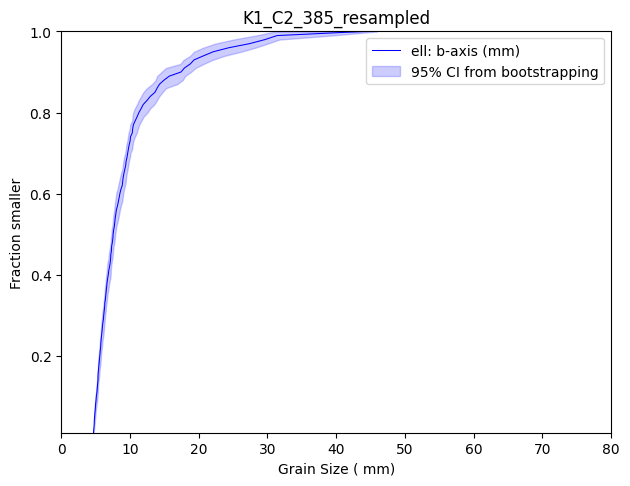

In [12]:
#plot gsd
plotting.plot_gsd(res_dict_bs[grain_id[0]][3],color='b',length_max=80,orientation='vertical',label_axes=True,units= 'mm')
#plot uncertainty
plotting.plot_gsd_uncert(res_dict_bs[grain_id[0]],color='b')
plt.legend([column_name,f'95% CI from {method}'])
plt.title(grain_id[0]);